In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import pinv
from sklearn.model_selection import train_test_split

class SinusoidalRegressor:
    def __init__(self):
        self.k = None
        self.weights = None

    def phi(self, x):
        """Generate basis functions for a given x"""
        return np.array([np.sin(i * x) if i % 2 == 1 else np.cos(i // 2 * x) for i in range(1, 2 * self.k + 2)])

    def fit(self, X_train, Y_train, k):
        """Train the model using pseudo-inverse"""
        self.k = k
        X_train = X_train.reshape(-1, 1)  # Ensure column vector
        Y_train = Y_train.reshape(-1, 1)  # Ensure column vector
        
        # Construct the design matrix Phi
        Phi = np.stack([self.phi(x) for x in X_train.flatten()], axis=0)  # Shape: (N, 2k+1)

        # Solve for weights using pseudo-inverse
        self.weights = pinv(Phi) @ Y_train  # Shape: (2k+1, 1)
        return self.weights

    def predict(self, X):
        """Make predictions"""
        if self.weights is None:
            raise ValueError("Model is not fitted yet.")
        X = X.reshape(-1, 1)  # Ensure column vector
        Phi = np.stack([self.phi(x) for x in X.flatten()], axis=0)  # Shape: (N, 2k+1)
        return Phi @ self.weights

    def rmse(self, X_val, Y_val):
        """Compute RMSE"""
        y_pred = self.predict(X_val)
        return np.sqrt(np.mean((Y_val - y_pred) ** 2))

# Load Data
np.random.seed(61)
csv_file = 'nonlinear-regression-data.csv'
data = pd.read_csv(csv_file)
x = np.array(data['X'])
y = np.array(data['Noisy_y'])

# Split Data
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=61)

# Initialize Model
sinusoidal_regressor = SinusoidalRegressor()


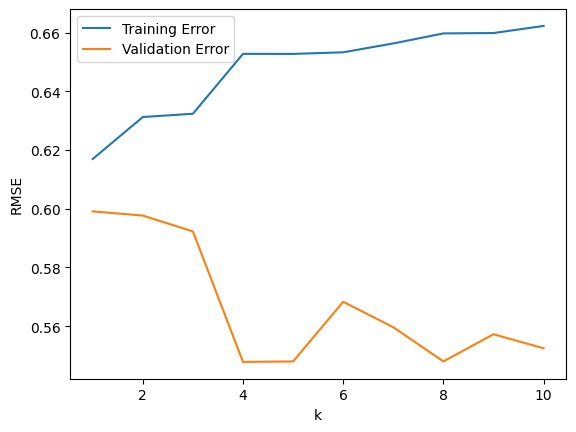

In [3]:

# Fit model and compute errors
train_errors = []
val_errors = []
for k in range(1, 11):
    sinusoidal_regressor.fit(X_train, Y_train, k)
    train_errors.append(sinusoidal_regressor.rmse(X_train, Y_train))
    val_errors.append(sinusoidal_regressor.rmse(X_val, Y_val))

# Plot Training and Validation Errors
plt.plot(range(1, 11), train_errors, label="Training Error")
plt.plot(range(1, 11), val_errors, label="Validation Error")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.legend()
plt.show()


In [8]:
optimal_k_train = np.argmin(train_errors) + 1
print(f"The optimal k that minimizes the training data is: {optimal_k_train}")

The optimal k that minimizes the training data is: 1


In [9]:
optimal_k_val = np.argmin(val_errors) + 1
print(f"The optimal k that minimizes the validation error is: {optimal_k_val}")

The optimal k that minimizes the validation error is: 4


### Compare the optimal k values that you found for the training error and validation error. Explain why they are different or the same.

The optimal k that minimizes the training error is: 1

The optimal k that minimizes the validation error is: 4

The optimal k values for training and validation errors are different. This discrepancy occurs because the training error measures how well the model fits the training data, while the validation error measures how well the model generalizes to unseen data. A lower k value might fit the training data very well (low training error) but may not generalize well to new data (high validation error). Conversely, a higher k value might provide a better balance between fitting the training data and generalizing to new data, resulting in a lower validation error. This phenomenon is known as overfitting and underfitting. The optimal k for validation error is typically preferred as it indicates better generalization performance.

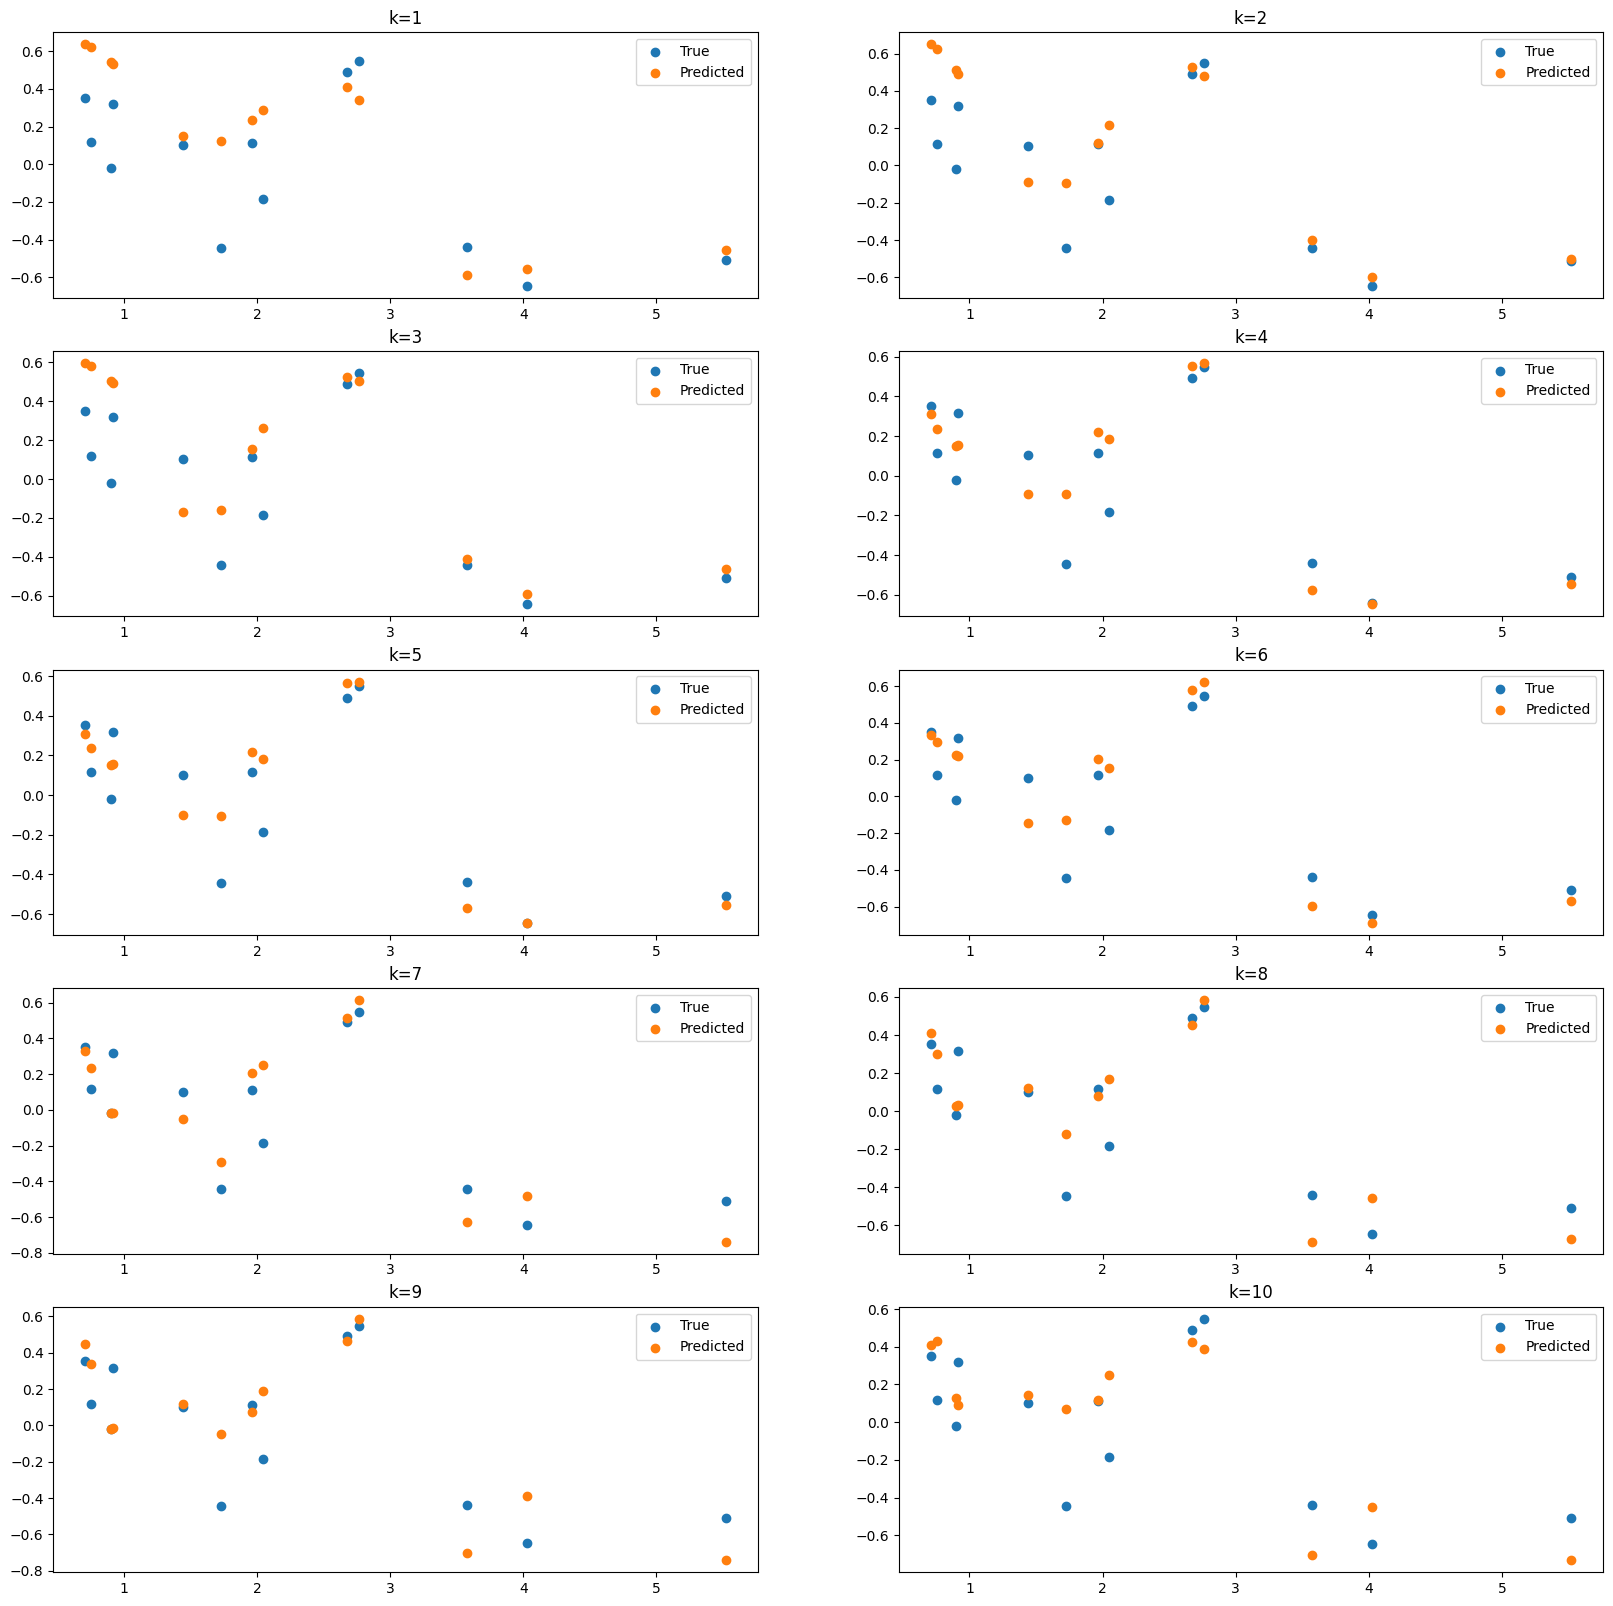

In [5]:

# Plot Predictions for Different k Values
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
for k in range(1, 11):
    sinusoidal_regressor.fit(X_train, Y_train, k)
    y_pred = sinusoidal_regressor.predict(X_val)
    
    ax = axs[(k - 1) // 2, (k - 1) % 2]
    ax.scatter(X_val, Y_val, label="True")
    ax.scatter(X_val, y_pred, label="Predicted")
    ax.set_title(f"k={k}")
    ax.legend()
plt.show()


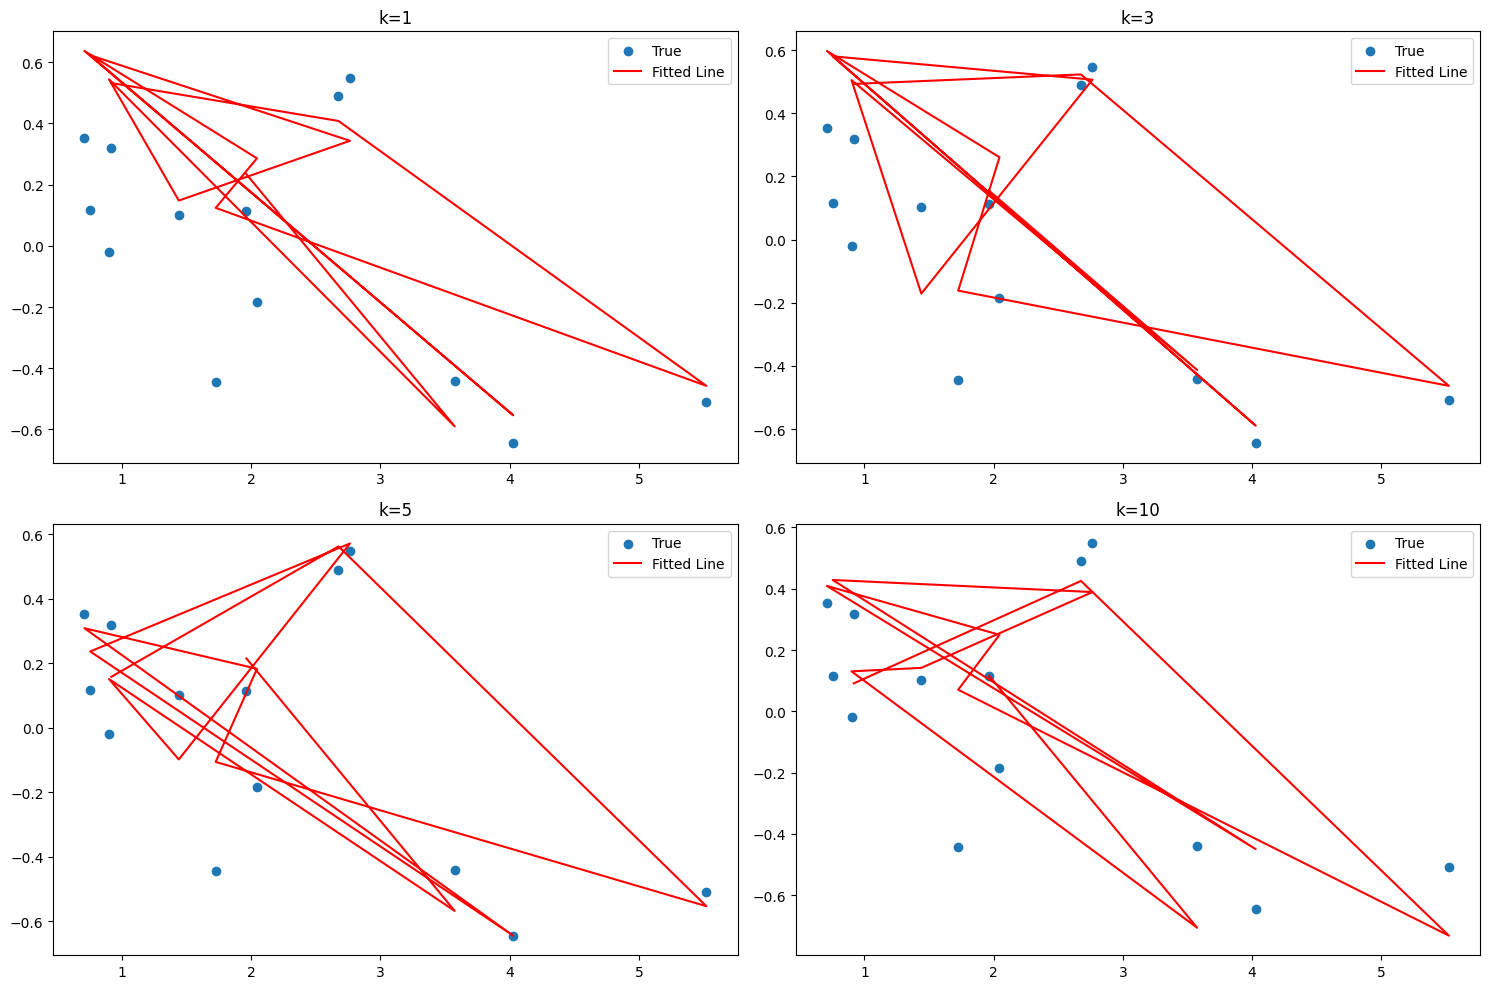

In [10]:
# Plot Predictions for k = 1, 3, 5, 10
k_values = [1, 3, 5, 10]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, k in enumerate(k_values):
    sinusoidal_regressor.fit(X_train, Y_train, k)
    y_pred = sinusoidal_regressor.predict(X_val)
    
    ax = axs[i // 2, i % 2]
    ax.scatter(X_val, Y_val, label="True")
    ax.plot(X_val, y_pred, color='red', label="Fitted Line")
    ax.set_title(f"k={k}")
    ax.legend()

plt.tight_layout()
plt.show()